In [56]:
import random

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from itertools import product
import Cython
from numba import njit
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from itertools import product
import Cython
from numba import njit

In [57]:
rho = 0.85
h = 0.016
m = 48
T = 1
M = 6 # cube root of number of unit cells in the L^3 volume, gives N=864 particles
L = np.cbrt((4*M**3)/rho)
sigma = 3.405 #Angstrom
epsilon = 119.8 #K
T = 2.0
sigma = 3.405 #Angstrom
epsilon = 119.8 #K
m = 48 # Be careful, m is also defined in the cython

tp = np.sqrt(48*epsilon/(m*sigma**2)) #*t

t_max = 1000
#r_total, v_total = verlet_algorithm(r_0, v_0, t_max)
# Todo: Scale time

In [58]:
def build_fcc():
    """
    :param M: integer. cube root of Number of unit cells
    :return: fcc grid for the L*L cube (np.array of shape (n_points, 3))
    """
    range_values_sc = np.linspace(-L/2, L/2, M+1)
    length_edge = np.abs(range_values_sc[0]-range_values_sc[1]) #L/(rho-1)
    sc_grid = np.array(list(product(range_values_sc, repeat=3)))
    sc_grid = sc_grid[sc_grid[:, 0] != -L/2]
    sc_grid = sc_grid[sc_grid[:, 1] != -L/2]
    sc_grid = sc_grid[sc_grid[:, 2] != -L/2]
    missing_points = []
    for point in sc_grid:
        p1 = [point[0]+0.5*length_edge, point[1], point[2]+0.5*length_edge]
        p2 = [point[0]+0.5*length_edge, point[1]+0.5*length_edge, point[2]]
        p3 = [point[0], point[1]+0.5*length_edge, point[2]+0.5*length_edge]
        missing_points.append(p1)
        missing_points.append(p2)
        missing_points.append(p3)
    missing_points = np.array(missing_points)
    x = sc_grid[:,0]
    y = sc_grid[:,1]
    z = sc_grid[:,2]
    x_m = missing_points[:,0]
    y_m = missing_points[:,1]
    z_m = missing_points[:,2]
    fcc_grid = np.concatenate([sc_grid, missing_points])

    return fcc_grid

fcc_example = build_fcc()
r_0 = fcc_example
#np.savetxt("fcc.txt", fcc_example, delimiter=" , ")

In [59]:
uniqueRows = np.unique(fcc_example, axis = 0)
print(uniqueRows.shape) 
print(fcc_example.shape)

(864, 3)
(864, 3)


In [60]:
v_0 = np.random.normal(0,np.sqrt(T/epsilon*m), (864, 3))
#np.savetxt("v_2.txt", v_0, delimiter=", ")

In [61]:
"""
r_0: Initial positions of the system
    r_0[i]: 1D-array with 3 values, the coordinates of the i'th particle
v_0: Initial velocities of the system particles
    v_0[i]: 1D-array with 3 values, the velocity values of the i'th particle
"""

"\nr_0: Initial positions of the system\n    r_0[i]: 1D-array with 3 values, the coordinates of the i'th particle\nv_0: Initial velocities of the system particles\n    v_0[i]: 1D-array with 3 values, the velocity values of the i'th particle\n"

In [62]:
t_max = 1500

path_r = "C:/Users/corin/CLionProjects/Verlet/cmake-build-debug/r_total_T0.txt"
path_v = "C:/Users/corin/CLionProjects/Verlet/cmake-build-debug/v_total_T0.txt"

r_total = np.loadtxt(path_r, delimiter=",")
v_total = np.loadtxt(path_v, delimiter=",")

r_total.shape

(1295007, 3)

In [64]:
r_total_cut = r_total[:864*1498 - r_total.shape[0], :]
r_total_cut.shape
v_total_cut = v_total[:864*1498 - v_total.shape[0], :]
r_total_reshaped = r_total_cut.reshape((1498, 864, 3))
v_total_reshaped = v_total_cut.reshape((1498, 864, 3))

Text(0.5, 0.92, 'Initial state of the Argon ')

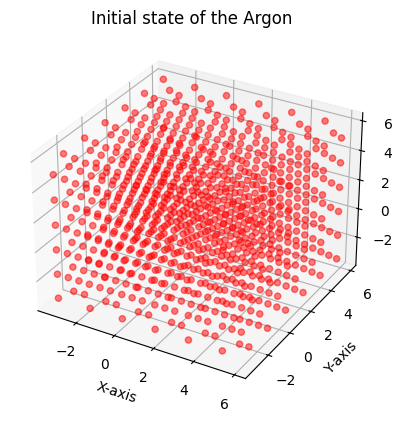

In [65]:
#Seeing how the initial state looks like
#ax = plt.figure().add_subplot(projection='3d')

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# Extract x, y, and z coordinates
x = r_0[:,0].flatten()
y = r_0[:,1].flatten()
z = r_0[:,2].flatten()

# Plot the points
ax.scatter(x, y, z, c='r', marker='o', alpha=0.5)

# Set labels
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')

# Set the title
ax.set_title('Initial state of the Argon ')

# Show the plot
#plt.show()

In [66]:
r_total_reshaped.shape

(1498, 864, 3)

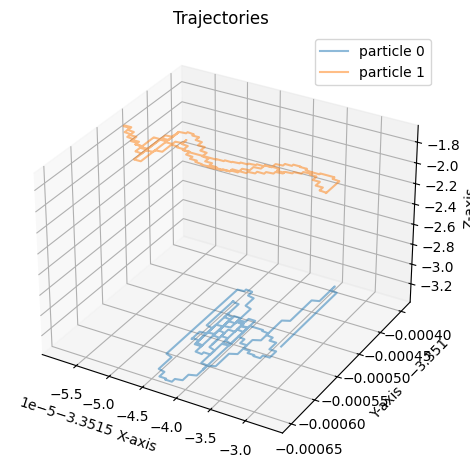

In [72]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.plot(r_total_reshaped[:,0,0], r_total_reshaped[:,0,1], r_total_reshaped[:,0,2], alpha=0.5, markersize= 10, label= "particle 0")
ax.plot(r_total_reshaped[:,1,0], r_total_reshaped[:,1,1], r_total_reshaped[:,1,2], alpha=0.5, markersize=10, label= "particle 1")

ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')
ax.set_title('Trajectories ')
plt.legend()
plt.tight_layout()

Text(0, 0.5, '$T^*$')

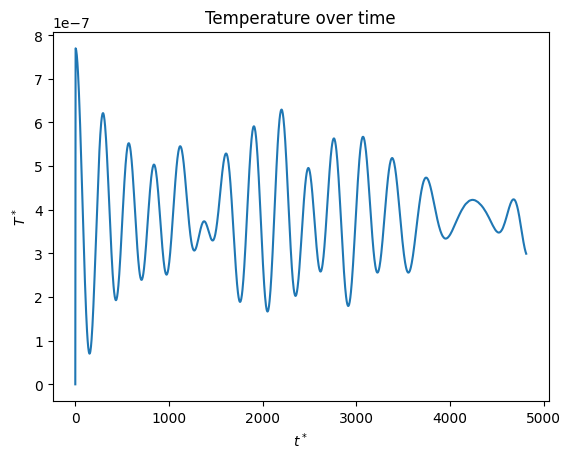

In [70]:
def Temperature(v):
    return 16*np.mean([(v_i[0]**2)+(v_i[1]**2)+(v_i[2]**2) for v_i in v])
T_total = [Temperature(v_t) for v_t in v_total_reshaped]
plt.plot(np.arange(v_total_reshaped.shape[0])*tp, T_total)
plt.title("Temperature over time")
plt.xlabel("$t^*$")
plt.ylabel("$T^*$")